# Aulinha de PyCaret

Autores: Stephanie Miho Urashima, Vitoria Rodrigues Silva, William Liaw

O módulo NLP da PyCaret (pycaret.nlp) é um módulo de aprendizado de máquina não supervisionado que pode ser usado para analisar textos. Ele vem integrado com uma ampla variedade de técnicas de pré-processamento, que é a etapa fundamental em qualquer problema de NLP. Ele transforma o texto bruto em um formato com o qual os algoritmos de aprendizado de máquina podem aprender!

Desde o primeiro lançamento, o módulo de NLP da PyCaret suporta apenas o idioma inglês mas possui mais de 5 algoritmos prontos para uso e mais de 10 plotagens para analisar o texto. Ele também implementa uma função exclusiva tune_model () que permite ajustar os hiperparâmetros de um modelo para otimizar o objetivo de aprendizado supervisionado, como AUC para classificação ou R2 para regressão.

## Instalando

In [ ]:
try:
    __import__('pycaret')
except ImportError:
    !pip install pycaret

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode activated.


## Dataset

Para este tutorial, usaremos dados do [Kiva Microfunds](https://www.kiva.org/). O Kiva Microfunds é uma organização sem fins lucrativos que permite que indivíduos emprestem dinheiro a empresários e estudantes de baixa renda em todo o mundo.



*   country: country of borrower (país de quem recebeu o dinheiro)
* **en (target): Personal story of borrower when applied for loan**
* gender: Gender (M=male, F=female)
* loan_amount: Amount of loan approved and disbursed
* nonpayment: Type of lender (Lender = personal registered user on Kiva website, Partner = microfinance institution who work with Kiva to find and fund loans)
* sector: sector of borrower
* status: status of loan (1-default, 0-repaid)

O dataset contém 6,818 amostras.

Neste tutorial, usaremos apenas a coluna "en" para criar um modelo de tópico.



In [ ]:
from pycaret.datasets import get_data
data = get_data('kiva')

,country,en,gender,loan_amount,nonpayment,sector,status
0,Dominican Republic,"""Banco Esperanza"" is a group of 10 women looki...",F,1225,partner,Retail,0
1,Dominican Republic,"""Caminemos Hacia Adelante"" or ""Walking Forward...",F,1975,lender,Clothing,0
2,Dominican Republic,"""Creciendo Por La Union"" is a group of 10 peop...",F,2175,partner,Clothing,0
3,Dominican Republic,"""Cristo Vive"" (""Christ lives"" is a group of 10...",F,1425,partner,Clothing,0
4,Dominican Republic,"""Cristo Vive"" is a large group of 35 people, 2...",F,4025,partner,Food,0


In [ ]:
# checando nossos dados
data.shape

(6818, 7)

In [ ]:
# simplificando nosso dataset para termos apenas 1000 amostras
data = data.sample(1000, random_state=786).reset_index(drop=True)
data.shape

(1000, 7)

## Criando um ambiente

Para utilizar qualquer modelo do Pycaret é necessario criar um ambiente, neste caso com a função setup(). 

Um dos pontos mais importantes é que o Pycaret automaticamente faz um pré-processamento do texto:
*   Retira números
*   Retira caracteres especiais (não alfanuméricos)
*   Tokenização
*   Extração de Bigramas e Trigramas
*   Lemmatização

Álem disso é possivel retirar stopwords especificas com o parametro custom_stopwords 

No entanto o PyCaret utiliza modelos do spacy e do textblob. 
Aparentemente já tem instalado no Colab, no entanto em outros ambientes talvez seja necessário instala-los com :

`python -m spacy download en_core_web_sm` <br/>
`python -m textblob.download_corpora` <br/>

Exatamente por isso que é praticamente inviavel usar o PyCaret para outras linguas. 

Obs: o setup cria transforma o dataframe em tuplas, ou seja, não é editável



In [ ]:
from pycaret.nlp import *
exp_nlp101 = setup(data = data, target = 'en', session_id = 123)

Description,Value
session_id,123
Documents,1000
Vocab Size,4573
Custom Stopwords,False


O session_id é a semente do gerador de números 
O Documents é a quantidade de amostras coletados 
Vocab size é o tamanho do vocabulário no corpus ápos o pré-processamento 

In [ ]:
def comparar_preprocessamento(data, data_setup, index, target):

  texto = ""
  for palavra in data_setup[0][index]:
    texto = texto + " " + palavra 

  print("texto original: ")
  print(data[target][index])

  print("texto processado: ")
  print(texto)

comparar_preprocessamento(data, exp_nlp101, 2, "en")

texto original: 
Ana Josefa is a single mother  living in San Cristobal whose four children, two boys and two girls, range from eleven to twenty-three years old.  Ana Josefa sells new and used womens clothing to support her family.  Most entrepreneurial clothing vendors in Anas area purchase clothing from outside of the community for resale locally.  Ana obtains some of her merchandise the same way, but also pays a nominal fee for the used clothing of her friends and family members and resells these items.  She also plans to use her loan to buy more new clothing at less expensive bulk rates to improve her profit margin.
texto processado: 
 live child boy girl range year sell use clothing support family entrepreneurial clothing vendor area purchase clothing community resale locally obtain merchandise way also pay nominal fee use clothing friend family member resell item also plan use loan buy new clothing less expensive bulk rate improve


Exemplo de como o texo é processado

"Praxides is married with four children who are all in primary school. She is a trained tailor. She also operates a small shop to supplement her tailoring business. From both her businesses she is able to meet her familys basic needs. <P>In addition to carrying out her businesses, Praxides is also employed in a local clothing shop where she trains students in clothes design and tailoring. Given the loan of $75 from PEMCI, Praxides intends to expand her tailoring shop and also to start her own training facility. She is a lady who is trying her best to empower herself financially and to support her young family."

['praxide', 'marry', 'child', 'primary', 'school', 'train', 'tailor', 'also', 'operate', 'small', 'shop', 'supplement', 'tailor', 'business', 'business', 'able', 'meet', 'addition', 'carry', 'business', 'praxide', 'also', 'employ', 'local', 'clothing', 'shop', 'train', 'student', 'clothe', 'design', 'tailor', 'give', 'loan', 'pemci', 'praxide', 'intend', 'tailor', 'shop', 'also', 'start', 'train', 'facility', 'lady', 'try', 'best', 'empower', 'financially', 'support', 'young', 'family']


#Criação de um modelo

Modelos tópicos, são modelos **ESTATÍSTICOS** utilizados para categorizar grandes quantidades de textos em tópicos.
Observação: um texto pode se encaixar em mais de um topico. 

O PyCaret pode treinar 5 modelos diferentes nos dados colocados no setup()

Para mais informações sobre LDA tem esse [paper](https://arxiv.org/pdf/1711.04305.pdf)


In [ ]:
models()

,Name,Reference
ID,,
lda,Latent Dirichlet Allocation,gensim/models/ldamodel
lsi,Latent Semantic Indexing,gensim/models/lsimodel
hdp,Hierarchical Dirichlet Process,gensim/models/hdpmodel
rp,Random Projections,gensim/models/rpmodel
nmf,Non-Negative Matrix Factorization,sklearn.decomposition.NMF


In [ ]:
lda = create_model('lda')

In [ ]:
print(lda)

LdaModel(num_terms=4573, num_topics=4, decay=0.5, chunksize=100)


O número de topicos criados é flexivel, mas o default é 4.
Somente o LDA tem a opção de usar o "multi_core" para agilizar o treinamento

In [ ]:
lda2 = create_model('lda', num_topics = 6, multi_core = True)

#Aplicação do modelo

A função assign_model() serve para aplicar o modelo no dataset.
Ele cria colunas para a porcentagem de cada topico, o topico dominante e a porcentagem do topico dominate no texto se for aplicavel, ou seja, se o modelo for estocástico (a soma das proporções forem igual a 1)

In [ ]:
exp_nlp101[1]

,country,en,gender,loan_amount,nonpayment,sector,status
0,Kenya,praxide marry child primary school train tailo...,F,75,partner,Services,0
1,Kenya,practitioner run year old life wife child biol...,M,1200,partner,Health,0
2,Dominican Republic,live child boy girl range year sell use clothi...,F,150,partner,Clothing,0
3,Kenya,phanice marry child daughter secondary school ...,F,150,lender,Services,1
4,Kenya,year old hotel kaptembwa operating hotel last ...,F,300,lender,Food,1
...,...,...,...,...,...,...,...
995,Dominican Republic,year old life year ago high school student bri...,F,275,partner,Services,1
996,Dominican Republic,live small eastern town raise child age loan y...,F,5000,partner,Food,0
997,Ecuador,live community minute city climate similar cue...,F,775,partner,Arts,0
998,Ecuador,distributor sell small store market borrow cou...,M,375,partner,Food,0


In [ ]:
lda_results = assign_model(lda)
lda_results.head()

,country,en,gender,loan_amount,nonpayment,sector,status,Topic_0,Topic_1,Topic_2,Topic_3,Dominant_Topic,Perc_Dominant_Topic
0,Kenya,praxide marry child primary school train tailo...,F,75,partner,Services,0,0.001901,0.006526,0.989895,0.001678,Topic 2,0.99
1,Kenya,practitioner run year old life wife child biol...,M,1200,partner,Health,0,0.284692,0.150754,0.562938,0.001615,Topic 2,0.56
2,Dominican Republic,live child boy girl range year sell use clothi...,F,150,partner,Clothing,0,0.002062,0.218126,0.777992,0.001820,Topic 2,0.78
3,Kenya,phanice marry child daughter secondary school ...,F,150,lender,Services,1,0.002106,0.072504,0.923531,0.001859,Topic 2,0.92
4,Kenya,year old hotel kaptembwa operating hotel last ...,F,300,lender,Food,1,0.001864,0.121781,0.874709,0.001646,Topic 2,0.87


# *Plotando* o modelo

&emsp;`plot_model()` pode ser usado para analisar o [corpus](https://www.dicio.com.br/corpus/) como um todo, ou apenas tópicos específicos extraídos do modelo de tópico. Consequentemente, `plot_model()` também pode ser usado sem receber nenhum modelo treinado como argumento. Veja os exemplos abaixo:

## Distribuição de frequência do corpus

In [ ]:
plot_model()

* Não se sabe exatamente como passar um corpus específico para a função `plot_model()`, visto que não é possível passar um `setup()` (e nem um `pandas.DataFrame`) como argumento.
* A função apresenta apenas 34 elementos no eixo x, apesar de ser um gráfico de 100 elementos.
* A escala do eixo y é ajustada automaticamente pela função, porém não se encontrou nenhuma maneira evidente de alterar a escala do gráfico arbitrariamente.
* Não parece ser possível alterar o número de elementos no gráfico (100).

## 100 bigramas mais frequentes no corpus

In [ ]:
plot_model(plot = 'bigram')

* Bigramas com "alto" número de símbolos são cortados, no eixo x, para fora da imagem.

In [ ]:
# Não consta no tutorial
plot_model(plot = 'trigram')

* Todos os trigamas constam apenas parcialmente na imagem.

## Distribuição da polaridade de sentimentos

In [ ]:
# Não consta no tutorial
plot_model(plot = 'sentiment')

* Não se sabe como a função `plot_model()` foi capaz de mostrar um gráfico de olaridade de sentimentos sem receber explicitamente um modelo.
* Ao que parece, a função tem como padrão algum limiar para excluir dados que constam do gráfico.
* Não é explicíto no gráfico o que cada valor de polaridade representa.

<sup>Cabe a ressalva de que os depoimentos de estudantes solicitando dinheiro de uma instituição sem fins lucrativos é, provavelmente, negativo. Pode-se apreender 0 como representativo de sentimentos negativos e 1 como representativo de sentimentos positivos.</sup>

## Distribuição de frequência do tópico 1

`plot_model` também pode ser usado para analizar os mesmos gráficos para tópicos específicos. Para gerar gráficos no escopo de um tópico, a funcão requer que um modelo seja passado como argumento. No exemplo abaixo, gerou-se a distribuição de frequência no `Topic 1`, como foi definido no parâmetro `topic_num`.

In [ ]:
plot_model(lda, plot = 'frequency', topic_num = 'Topic 1')

* A função `plot_model()` não aceita mais de um tópico como parâmetro (não é possível estudar uma lista de tópicos/mais de um tópico em um mesmo gráfico desta função).

## Distribuição de tópicos

In [ ]:
plot_model(lda, plot = 'topic_distribution')

&emsp;Cada documento é (genericamente) um aglomerado de tópicos, e não representa apenas um tópico específico. Entretanto, se a tarefa é classificar o documento em apenas um tópico, não é errado (segundo a documentação do PyCaret) utilizar a correlação documento-tópico mais alta. No gr;afico acima, cada documento é categorizado conforme o valor mais alto apresentado entre os pesos de cada tópico.

<sup> Acredita-se que o tópico 9.4 do [*notebook* iniciante do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Beginner%20-%20NLP101.ipynb) está equivocado.</sup>

&emsp;Pode-se observar que a maioria dos documentos foi classificado no `Topic 1`, com poucos no `Topic 3`. Ao posicionar o cursor em cima das 'barras' é possível averiguar a ideia básica dos temas de cada tópico pelas palavras-chave. No [*notebook* intermediário do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Intermediate%20-%20NLP102.ipynb), mostra-se como usar `custom_stopwords` para analizar este gráfico.

## T-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
plot_model(lda, plot = 'tsne')

t-SNE é uma redução dimensional não linear, ou seja, uma técnica conveniente para incorporar dados para a visualização em espaços com poucas dimensões (duas ou três).

[Saiba mais](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

* O gráfico apresenta os dados como pontos, os quais, ao posicionar o cursor sobre, apresentam os pesos dos 3 primeiros tópicos (mesmo quando o quarto peso, `Topic 3` é o mais preponderante).

## Uniform Manifold Approximation and Projection Plot (UMAP)

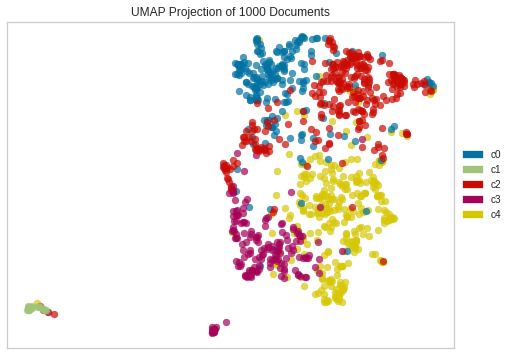

In [ ]:
plot_model(lda, plot = 'umap')

UMAP é uma técnica usada para redusir as várias dimesões dos dados. É similar ao t-SNE e ao PCA, por projetar em espaços de poucas dimensões. A UMAP é construída a partir de uma estrutura teórica baseada em geometria riemaniana e topologia algébrica. <sup>Eu (William) não faço ideia do que esse último período significa.</sup>

[Saiba mais](https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668) <~ hyperlink para uma página sem acesso liberado de graça, do Medium.

## Avaliando o modelo

&emsp;Uma outra maneira de analizar a performance do modelo é utilizar a função `evaluate_model()` que mostra uma interface gráfica para todos os gráficos disponíveis para um dado modelo. Essa função utiliza internamente `plot_model()`.

<sup>ou seja... é exatamente a mesma coisa **com uma interface gráfica**, incapaz de analizar o corpus inteiro e, ainda, sem conseguir apresentar mais de um tópico em apenas um gráfico.</sup>

In [ ]:
evaluate_model(lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

## Arquivando o modelo

In [ ]:
save_model(lda,'Final LDA Model 31Aug2020')

Model Succesfully Saved


* Salva o modelo em um arquivo necessariamente no diretório em que o comando é executado.
* Caso já exista um arquivo com o nome especificado, a função atualiza o arquivo (sem demonstrar indícios de tal).

## Usando um modelo arquivado

In [ ]:
saved_lda = load_model('Final LDA Model 31Aug2020')

Model Sucessfully Loaded


In [ ]:
print(saved_lda)

LdaModel(num_terms=4573, num_topics=4, decay=0.5, chunksize=100)


## Próximos passos

[*Notebook* intermediário do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Intermediate%20-%20NLP102.ipynb)